In [5]:
import os
import torch
import random
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil
import time
import xml.etree.ElementTree as et
import splitfolders
import wget
import requests
import pickle

from io import BytesIO
from zipfile import ZipFile
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
BATCH_SIZE = 32

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print('Connected device:', device)

Connected device: cuda


**Загружаем датасет**

In [ ]:
# перенесем в папку data наш датасет
source_dir = "C:/Users/илья/Desktop/MIPT/Хакатон/Project/Грибы"
target_dir = '/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data'
folder_names = os.listdir(source_dir)
for folder_name in folder_names:
    shutil.move(os.path.join(source_dir, folder_name), target_dir)

# os.mkdir('data')
# для загрузки с гугл диска
# url = 'https://drive.google.com/uc?export=download&id=120xqh0mYtYZ1Qh7vr-XFzjPbSKivLJjA'
# file_name = wget.download(url, 'data/')

# with ZipFile(file_name, 'r') as zip_file:
#     zip_file.extractall()

# link_lst = [eatable, poisonous]
# for link in link_lst:
#     wget.download(link, 'data/')

****Разделим данные на train, test, valid****

In [8]:
# определяем путь к папке с исходными файлами
input_folder = "/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data" #

# разбиваем датасет на папки с процентным соотношением числа файлов
splitfolders.ratio(input_folder, '/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data/mooshrooms_splited', ratio = (0.7, 0.15, 0.15), seed=13, group_prefix=None)



Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  6.18 files/s]
Copying files: 3 files [00:00,  5.00 files/s]
Copying files: 4 files [00:01,  3.58 files/s]
Copying files: 5 files [00:01,  3.14 files/s]
Copying files: 6 files [00:01,  2.86 files/s]
Copying files: 7 files [00:02,  2.75 files/s]
Copying files: 8 files [00:08,  2.10s/ files]
Copying files: 16 files [00:08,  2.04 files/s]
Copying files: 26 files [00:08,  4.74 files/s]
Copying files: 34 files [00:08,  7.58 files/s]
Copying files: 45 files [00:08, 12.81 files/s]
Copying files: 56 files [00:08, 19.37 files/s]
Copying files: 68 files [00:09, 27.89 files/s]
Copying files: 80 files [00:09, 38.00 files/s]
Copying files: 91 files [00:09, 47.50 files/s]
Copying files: 103 files [00:09, 53.70 files/s]
Copying files: 115 files [00:09, 64.45 files/s]
Copying files: 125 files [00:09, 71.38 files/s]
Copying files: 136 files [00:09, 79.63 files/s]
Copying files: 147 files [00:09, 84.65 files/s]
Copying files: 158 

In [15]:
# Training dataset.
train_dataset = ImageFolder(
    root = "/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data/mooshrooms_splited/train"
)
# Validation dataset.
valid_dataset = ImageFolder(
    root = '/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data/mooshrooms_splited/val'
)
# Test dataset
test_dataset = ImageFolder(
    root = '/content/drive/MyDrive/ColabNotebooks/neuro_project/binary_mushroom_classification_model/data/mooshrooms_splited/test'
)

**Произведем нормализацию и аугментацию - автовыравнивание изображений и автоконтраста (чтобы улучшить обобщающую способность моделей и внизить риск переобучения).**

In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset.transform = transforms.Compose([
    transforms.Resize([80, 80]),
    transforms.RandomHorizontalFlip(), # augmentations
    transforms.RandomAutocontrast(), # augmentations
    transforms.RandomEqualize(), # augmentations
    transforms.ToTensor(),
    normalize
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize([80, 80]),
    transforms.ToTensor(),
    normalize
])

test_dataset.transform = transforms.Compose([
    transforms.Resize([80, 80]),
    transforms.ToTensor(),
    normalize
])


In [17]:
# Training data loaders.
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True
)
# Validation data loaders.
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False
)
# Test data loaders
test_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False
)

Возьмём предобученную нейросеть GoogLeNet.

Добавим один слой с выходным параметром out_feature=2

Замораживаем все слои, кроме последних двух.

In [18]:
def google(): # pretrained=True для tensorflow
    model = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(1024, len(train_dataset.classes))

    for param in model.parameters():
        param.requires_grad = True
    model.inception3a.requires_grad = False
    model.inception3b.requires_grad = False
    model.inception4a.requires_grad = False
    model.inception4b.requires_grad = False
    model.inception4c.requires_grad = False
    model.inception4d.requires_grad = False
    model.inception4e.requires_grad = False
    return model

**Определяем функцию обучения модели.**

In [19]:
def train(model, optimizer, train_loader, val_loader, epoch=10):
    loss_train, acc_train = [], []
    loss_valid, acc_valid = [], []
    count = 0
    for epoch in tqdm(range(epoch)):
        losses, equals = [], []
        torch.set_grad_enabled(True)

        # Train.
        model.train()
        for i, (image, target) in enumerate(train_loader):
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [x.item() for x in torch.argmax(output, 1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        acc_train.append(np.mean(equals))
        losses, equals = [], []
        torch.set_grad_enabled(False)

        # Validate.
        model.eval()
        for i , (image, target) in enumerate(valid_loader):
            image = image.to(device)
            target = target.to(device)

            output = model(image)
            loss = criterion(output,target)

            losses.append(loss.item())
            equals.extend(
                [y.item() for y in torch.argmax(output, 1) == target])

        loss_valid.append(np.mean(losses))
        acc_valid.append(np.mean(equals))

    return loss_train, acc_train, loss_valid, acc_valid

In [20]:
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

model = google()
print('Model: GoogLeNet\n')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)

loss_train, acc_train, loss_valid, acc_valid = train(
model, optimizer, train_loader, valid_loader)
print('acc_train:', acc_train, '\nacc_valid:', acc_valid)
print('loss_train:', loss_train, '\nloss_valid:', loss_valid)
# del model
# torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth

  0%|          | 0.00/49.7M [00:00<?, ?B/s]
 18%|█▊        | 9.20M/49.7M [00:00<00:00, 96.4MB/s]
 40%|████      | 20.0M/49.7M [00:00<00:00, 106MB/s] 
 71%|███████▏  | 35.4M/49.7M [00:00<00:00, 132MB/s]
100%|██████████| 49.7M/49.7M [00:00<00:00, 103MB/s]


Model: GoogLeNet




100%|██████████| 10/10 [02:15<00:00, 13.50s/it]

acc_train: [0.66728280961183, 0.8012939001848429, 0.8539741219963032, 0.899260628465804, 0.9186691312384473, 0.9473197781885397, 0.9621072088724584, 0.9805914972273567, 0.9768946395563771, 0.9833641404805915] 
acc_valid: [0.7532467532467533, 0.7489177489177489, 0.7878787878787878, 0.7402597402597403, 0.8095238095238095, 0.8008658008658008, 0.7922077922077922, 0.8181818181818182, 0.8181818181818182, 0.8008658008658008]
loss_train: [0.6049040529657813, 0.44778916064430685, 0.3495841674944934, 0.2794615998864174, 0.22193538156502388, 0.15278012962902293, 0.11927213591030415, 0.08515388781533521, 0.07754831224241678, 0.05910865044878686] 
loss_valid: [0.5070693418383598, 0.4731632936745882, 0.461917320266366, 0.5015477556735277, 0.44326549023389816, 0.48698725923895836, 0.5097308401018381, 0.533448863774538, 0.580756451934576, 0.5884341057389975]


**Проверяем точность модели**

In [ ]:
correct = 0
total = 0
with torch.no_grad():
   for data in test_loader:
     images, labels = data
    #  print(images)
    #  print(f"Label: {labels.size(0)}")
     outputs = model(images)
     _, predicted = torch.max(outputs.data, 1)
    #  print(f"foft max: {torch.max(outputs.data, 1)}")
     total += labels.size(0)
     correct += (predicted == labels).sum().item()

print(f'Model accuracy: {100 * correct // total} %')

Model accuracy: 75 %


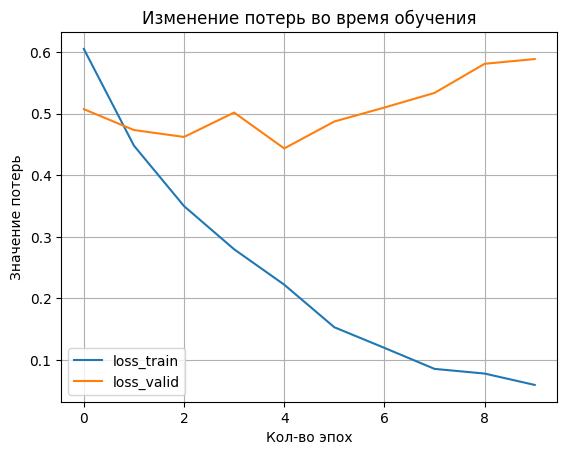

In [26]:
import pandas as pd

data = []
data.append(loss_train)
data.append(loss_valid)

df = pd.DataFrame(data).transpose()
df.columns =['loss_train', 'loss_valid']

# Изменение потерь во время обучения:
df.plot(
    title='Изменение потерь во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение потерь'
    );

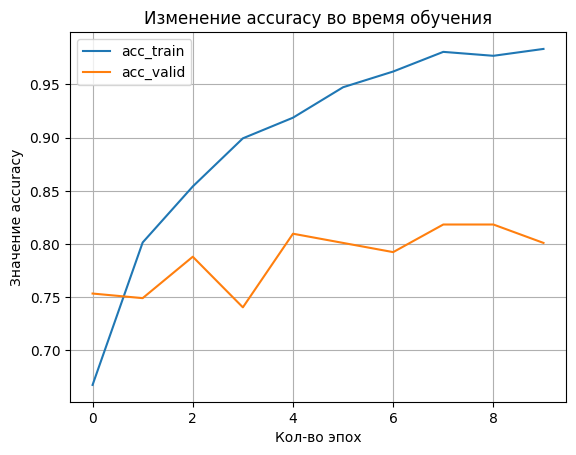

In [28]:
data = []
data.append(acc_train)
data.append(acc_valid)

df = pd.DataFrame(data).transpose()
df.columns =['acc_train', 'acc_valid']

# Изменение accuracy во время обучения
df.plot(
    title='Изменение accuracy во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение accuracy'
);

**Работоспособность модели**

In [ ]:

url = "https://avatars.mds.yandex.net/i?id=08ecf40616c96615f057052aa310bbb1ac90582d-4143030-images-thumbs&n=13"

# функция, приводящая изображение в нужный для модели формат
def to_prepaate_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # load image in RGB mode (png files contains additional alpha channel)
    img = img.convert('RGB')

    # set up transformation to resize the image
    resize = transforms.Resize([70, 70])
    img = resize(img)
    to_tensor = transforms.ToTensor()

    # apply transformation and convert to Pytorch tensor
    img_tenzor = to_tensor(img)
    # torch.Size([3, 70, 70])
    img_norm = normalize(img_tenzor)
    # to_normalize = transforms.Normalize()

    # add another dimension at the front to get NCHW shape
    tensor = img_tenzor.unsqueeze(0)
    # torch.Size([1, 3, 70, 70])
    return tensor

image = to_prepaate_img(url)
outputs = model(image)
_, predicted = torch.max(outputs.data, 1)
classes = {
           "tensor(0)": "eatble",
           "tensor(1)": "not eatble"
           }
# print(classes[tensor[0]])
print(classes[str(predicted[0])])
# img

eatble


In [ ]:
#  сохраняем модель в объект pkl
pickle.dump(model, open("model.pkl", "wb"))